In [12]:
import pandas as pd 
import numpy as np
import os
from Bio.SeqUtils import xGC_skew, GC_skew

# ORIGINAL DATA

In [31]:
original_PATH = "data/HGTDB/temp_data/"

In [43]:
def preprocess(path_to_file):
    df = pd.read_csv(path_to_file, sep='\t', index_col="Synonym", na_values=None)
    
    to_drop = ["Coordinates", "GCRegion", "PID", "Gene name", "SimMah", "SimT", "Sim1", "Sim2", "Sim3","Function", "COG","SimGC"]
    df.drop(columns=to_drop, inplace=True)
    
    #rename
    #df.rename(columns={"Gene name": "Genename", "Dev.AA": "AADev"}, inplace=True)
    # rename some columns & index
    df.rename(columns={ "Dev.AA": "AADev"}, inplace=True)
    df.index.names = ["ID"]
    
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

    # HGT column - target column
        # reorder HGT column to the end
    cols = df.columns.tolist()
    cols.append(cols.pop(cols.index("HGT")))
    df = df[cols]
    # binary encoding HGT: HGT: 1, non-HGT: 0, excluded from analysis: 0
    # TODO: ask Josefa whether to delete f or not
    hgt_dict = {"":0, "H":1, "f": 0}
    # Trouble when no f is found
    # print('{} genes were excluded from analysis'.format(df["HGT"].value_counts()["f"]))
    print('{} genes were excluded from analysis'.format(df[df['HGT'] == 'f']['HGT'].count()))
    df.replace({"HGT":hgt_dict}, inplace=True)

    # binary encoding strand
    strand_dict = {'+':0, '-':1}
    df.replace({"Strand":strand_dict}, inplace=True)

    # change missing values to naN
    #df["Genename"] = np.where(df["Genename"] == "-", df.index, df["Genename"])
    #df.replace("", np.nan, inplace=True)
    #df.replace("-", np.nan, inplace=True)
    df["FunctionCode"].replace('-','',inplace=True)
    # binary encoding AADev
    df["AADev"].replace(np.nan, 0, inplace=True)
    df["AADev"].replace('', 0, inplace=True)
    df["AADev"] = np.where(df["AADev"] != 0, 1, df["AADev"])
    
    
    # taken from Josefa's correct strain
    gc_df = df.loc[df["GCT"] == 0]
    print("GCT == 0:")
    if len(gc_df.index) >= 1:
        print(gc_df.index.to_list())
        # deletes all non-HGT genes with GCT = 0 & prints a warning otherwise
        for gene in gc_df.index.to_list():
            if gc_df.loc[gene]["HGT"] == 0:
                df.drop(index=gene, inplace=True)
                print("deleted {}".format(gene))
            else:
                print("Warning: a HGT gene as an abnormal GCT of 0!")
    else:
        print("none")

    # if an index is duplicate
    print("duplicated index?")
    idx=pd.Index(df.index)#.values)
    duplicate_lst = idx.duplicated(keep=False)
    if True in duplicate_lst:
        print("There are duplicates! \nchanged to:")
            # list of rownumber whose indices are doubled
        duplicate_row_lst = np.where(duplicate_lst == True)[0].tolist()
        #print(duplicate_row_lst)
        duplicate_ind_lst = idx.to_list()
            # correct indices:
        first = True
        unique_ID = 0
        for row in duplicate_row_lst:
            if first:
                new_ind = "{}a_{}".format(duplicate_ind_lst[row], unique_ID)
                idx = idx.delete(row).insert(row, new_ind)
                first = False
            else:
                new_ind = "{}b_{}".format(duplicate_ind_lst[row], unique_ID)
                idx = idx.delete(row).insert(row, new_ind)
                first = True
            print(new_ind)
            unique_ID +=1
            # set corrected indices as new indices for the df
        df.set_index(idx, inplace=True)#pd.Series(duplicate_ind_lst), inplace=True).rename_axis("ID") #set_axis(duplicate_ind_lst,axis=0, inplace=True)
    else:
        print("no")
    
    return df

In [38]:
for genome in os.listdir(original_PATH):
    genome_df = pd.read_csv(f'data/HGTDB/temp_data/{genome}', sep='\t', na_values=None)
    
    genome_nulls = genome_df[genome_df.isna().any(axis=1)]
    if len(genome_nulls) > 0:
        print(genome)
        print(genome_nulls)
            

NameError: name 'original_PATH' is not defined

In [39]:
df = pd.read_csv(f'data/HGTDB/temp_data/scoel.tsv', sep='\t')

In [40]:
df

,Coordinates,Strand,Length,PID,Gene name,Synonym,FunctionCode,COG,GCRegion,HGT,...,GC3,SD3,Sim3,GCT,SDT,SimT,SimGC,Mah,SimMah,Dev.AA
0,446..1123,+,675,21218583,SCEND.02c,SCO0001,-,-,,,...,80.5,-2.5,-2.0,71.1,-0.3,0.0,1.0,13.6,0.0,+C 3.4
1,1252..3813,+,2559,21218584,SC8E7.42c,SCO0002,-,-,,,...,88.5,-0.8,0.0,70.7,-0.4,0.0,0.0,4.1,0.0,
2,3869..6220,+,2349,21218585,SC8E7.41c,SCO0003,-,-,,,...,78.1,-3.0,-2.0,68.5,-1.1,0.0,0.0,12.4,0.0,
3,6979..7175,+,192,21218586,SC1C9.01,SCO0004,-,-,,,...,76.1,-3.4,-3.0,67.5,-1.4,0.0,0.0,55.2,2.0,+R -3.0
4,7189..9309,+,2118,21218587,SC1C9.02,SCO0005,-,-,,,...,87.6,-1.0,0.0,70.8,-0.4,0.0,0.0,4.4,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,3476105..3477664,-,1557,21221609,SCE87.23c,SCO3172,-,-,,,...,97.5,1.0,0.0,72.0,-0.1,0.0,0.0,2.8,0.0,
3027,3477824..3478471,+,645,21221610,SCE87.24,SCO3173,-,-,,,...,93.5,0.2,0.0,72.8,0.2,0.0,0.0,10.0,0.0,
3028,3478490..3479314,-,822,21221611,SCE87.25c,SCO3174,-,-,,,...,93.5,0.2,0.0,71.8,-0.1,0.0,0.0,6.4,0.0,
3029,3479362..3479847,+,483,21221612,SCE87.26,SCO3175,-,-,,,...,96.9,0.9,0.0,70.4,-0.5,0.0,0.0,8.0,0.0,+Y 3.3


In [44]:
df = preprocess('data/HGTDB/temp_data/scoel.tsv')

11 genes were excluded from analysis
GCT == 0:
none
duplicated index?
There are duplicates! 
changed to:
SCO1514a_0
SCO1514b_1
SCO2486a_2
SCO2486b_3


In [45]:
df

,Strand,Length,FunctionCode,GC1,SD1,GC2,SD2,GC3,SD3,GCT,SDT,Mah,AADev,HGT
ID,,,,,,,,,,,,,,
SCO0001,0,675,,69.5,-0.6,63.3,2.0,80.5,-2.5,71.1,-0.3,13.6,1,0
SCO0002,0,2559,,74.0,0.2,49.6,-0.3,88.5,-0.8,70.7,-0.4,4.1,0,0
SCO0003,0,2349,,73.6,0.1,53.8,0.4,78.1,-3.0,68.5,-1.1,12.4,0,0
SCO0004,0,192,,76.1,0.6,50.3,-0.2,76.1,-3.4,67.5,-1.4,55.2,1,0
SCO0005,0,2118,,74.8,0.3,50.1,-0.2,87.6,-1.0,70.8,-0.4,4.4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCO3172,1,1557,,67.9,-0.8,50.6,-0.2,97.5,1.0,72.0,-0.1,2.8,0,0
SCO3173,0,645,,80.6,1.3,44.4,-1.2,93.5,0.2,72.8,0.2,10.0,0,0
SCO3174,1,822,,72.0,-0.1,49.8,-0.3,93.5,0.2,71.8,-0.1,6.4,0,0


In [53]:
df2 = preprocess('data/HGTDB/temp_data/xcamp.tsv')

56 genes were excluded from analysis
GCT == 0:
none
duplicated index?
no


In [55]:
df2

,Strand,Length,FunctionCode,GC1,SD1,GC2,SD2,GC3,SD3,GCT,SDT,Mah,AADev,HGT
ID,,,,,,,,,,,,,,
XCC0001,0,1326,,67.7,0.0,43.3,-0.8,86.7,0.7,65.9,0.1,7.4,0,0
XCC0002,0,1098,,70.8,0.5,39.5,-1.6,83.4,0.3,64.6,-0.2,11.0,0,0
XCC0003,0,1104,,74.0,1.1,49.1,0.3,73.4,-1.1,65.5,0.0,12.2,0,0
XCC0004,0,2442,,67.7,0.0,40.2,-1.4,87.0,0.8,65.0,-0.1,2.9,0,0
XCC0005,0,840,,67.6,0.0,52.7,1.0,83.3,0.3,67.9,0.6,12.8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XCC4238,1,1338,,75.4,1.3,47.9,0.1,74.0,-1.0,65.8,0.1,10.7,0,0
XCC4239,1,2856,,68.1,0.1,46.8,-0.2,79.5,-0.2,64.8,-0.2,4.4,0,0
XCC4240,1,1719,,61.5,-1.1,45.6,-0.4,90.6,1.3,65.9,0.1,6.1,0,0


In [56]:
df3 = pd.read_csv('data/HGTDB/temp_data/xcamp.tsv', sep='\t')

In [57]:
df3

,Coordinates,Strand,Length,PID,Gene name,Synonym,FunctionCode,COG,GCRegion,HGT,...,GC3,SD3,Sim3,GCT,SDT,SimT,SimGC,Mah,SimMah,Dev.AA
0,42..1370,+,1326,21229479,dnaA,XCC0001,-,-,,,...,86.7,0.7,0,65.9,0.1,0,0,7.4,0,
1,1646..2746,+,1098,21229480,dnaN,XCC0002,-,-,,,...,83.4,0.3,0,64.6,-0.2,0,0,11.0,0,
2,3633..4739,+,1104,21229481,recF,XCC0003,-,-,,,...,73.4,-1.1,0,65.5,0.0,0,0,12.2,0,
3,4853..7297,+,2442,21229482,gyrB,XCC0004,-,-,,,...,87.0,0.8,0,65.0,-0.1,0,0,2.9,0,
4,7359..8201,+,840,21229483,-,XCC0005,-,-,,,...,83.3,0.3,0,67.9,0.6,0,0,12.8,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4176,5069466..5070806,-,1338,21233655,thdF,XCC4238,-,-,,,...,74.0,-1.0,0,65.8,0.1,0,0,10.7,0,
4177,5070829..5073687,-,2856,21233656,-,XCC4239,-,-,,,...,79.5,-0.2,0,64.8,-0.2,0,0,4.4,0,
4178,5073624..5075345,-,1719,21233657,-,XCC4240,-,-,,,...,90.6,1.3,0,65.9,0.1,0,0,6.1,0,
4179,5075361..5075807,-,444,21233658,rnpA,XCC4241,-,-,,,...,76.5,-0.6,0,69.4,1.0,0,0,31.7,2,+PR 3.1 3.9


In [58]:
df4 = pd.read_csv('data/HGTDB/temp_data/sau1.tsv', sep='\t')

In [62]:
for i in df4['Synonym']:
    print(i)

SA0001
SA0002
SA0003
SA0004
SA0005
SA0006
SA0007
SA0008
SA0009
SA0010
SAS001
SA0011
SA0012
SA0013
SA0014
SA0015
SA0016
SA0017
SA0018
SA0019
SA0020
SA0021
SA0022
SA0023
SA0024
SA0025
SA0026
SA0028
SA0028
SAS002
SA0029
SA0030
SA0031
SA0032
SA0033
SA0034
SA0035
SA0036
SA0037
SA0038
SA0039
SA0040
SA0041
SA0042
SA0043
SA0044
SA0045
SA0046
SA0047
SA0048
SA0049
SA0050
SA0051
SA0052
SA0053
SA0054
SA0055
SA0056
SA0057
SA0058
SA0059
SA0060
SA0061
SA0063
SA0063
SA0064
SA0065
SA0066
SA0067
SA0069
SA0069
SA0070
SA0071
SA0072
SA0073
SAS003
SA0074
SA0075
SA0076
SA0077
SA0078
SA0079
SA0080
SA0081
SA0082
SA0083
SA0084
SA0085
SA0086
SA0087
SA0088
SA0089
SA0090
SA0091
SA0092
SA0093
SA0094
SA0095
SA0096
SA0097
SA0098
SA0099
SA0100
SA0102
SA0102
SA0103
SA0104
SA0106
SA0106
SA0107
SA0108
SA0109
SA0110
SA0111
SA0112
SA0113
SA0114
SA0115
SA0116
SA0117
SA0118
SA0119
SA0120
SA0121
SA0122
SAS004
SA0123
SA0124
SA0125
SA0126
SA0127
SA0128
SA0129
SA0130
SA0131
SA0132
SA0133
SA0134
SA0135
SA0136
SA0137
SA0138
SA0139

In [63]:
df4[df4['Synonym']=='SA2486']

,Coordinates,Strand,Length,PID,Gene name,Synonym,FunctionCode,COG,GCRegion,HGT,...,GC3,SD3,Sim3,GCT,SDT,SimT,SimGC,Mah,SimMah,Dev.AA
2573,2794635..2795099,+,462,15928279,-,SA2486,-,-,,,...,19.4,-0.8,0,32.3,-0.3,0,0,32.6,0,
2574,2795337..2796755,+,1416,15928280,-,SA2486,P,COG0471,,,...,30.2,1.9,1,38.3,1.7,1,1,19.7,0,+W 3.6


# PRE-PROCESSED DATA

In [33]:
PATH = "data/HGTDB/preprocessed_data/"

In [34]:
for genome in os.listdir(PATH):
    genome_df = pd.read_csv(f'data/HGTDB/preprocessed_data/{genome}', na_values=None).drop(columns='FunctionCode')
    
    genome_nulls = genome_df[genome_df.isna().any(axis=1)]
    if len(genome_nulls) > 0:
        print(genome)
        print(genome_nulls)

vvul2c2.csv
             ID  Strand  Length   GC1  SD1   GC2  SD2   GC3  SD3   GCT  SDT   
1695  nanb_1695     NaN       0  53.0 -0.4  34.5 -0.9  54.2  0.6  47.2 -0.2  \
1696  nana_1696     NaN       0  34.1 -4.6  29.3 -2.3  31.7 -2.9  31.7 -4.8   

        Mah  AADev  HGT  
1695   34.2      1    0  
1696  326.1      1    0  
vvul2c1.csv
             ID  Strand  Length   GC1  SD1   GC2  SD2   GC3  SD3   GCT  SDT   
3260  nana_3260     NaN       0  60.4  0.9  31.6 -1.5  44.3 -0.4  45.4 -0.4  \
3261  nanb_3261     NaN       0  58.5  0.6  40.1  0.6  45.5 -0.2  48.0  0.3   

       Mah  AADev  HGT  
3260  19.6      1    0  
3261   9.3      1    0  
scoel.csv
           ID  Strand  Length  GC1  SD1  GC2  SD2  GC3  SD3  GCT  SDT  Mah   
3030  SCO3176       1    1749  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  \

      AADev  HGT  
3030      0    0  


In [60]:
df = pd.read_csv('data/HGTDB/preprocessed_data/vvul2c2.csv', na_values=None, index_col='ID').drop(columns=["FunctionCode","Strand","Length","SD1","SD2","SD3","SDT"]) 

In [61]:
df

,GC1,GC2,GC3,GCT,Mah,AADev,HGT
ID,,,,,,,
-a_0,54.5,37.0,50.8,47.4,22.3,1,0
-b_1,53.8,35.3,54.5,47.9,80.6,1,0
-a_2,56.9,37.9,52.1,49.0,27.4,1,0
-b_3,59.2,35.5,54.6,49.8,36.9,1,0
-a_4,60.6,33.3,40.9,44.9,193.2,1,0
...,...,...,...,...,...,...,...
-a_1692,58.8,36.5,42.4,45.9,119.5,1,0
-b_1693,62.7,40.9,53.7,52.4,22.8,1,0
-a_1694,59.4,38.5,49.8,49.2,33.4,1,0


In [62]:
df.max()

GC1       70.3
GC2       56.1
GC3       68.2
GCT       58.3
Mah      803.0
AADev      1.0
HGT        1.0
dtype: float64

In [63]:
df.min()

GC1      22.2
GC2      14.0
GC3      21.6
GCT      23.0
Mah      10.1
AADev     1.0
HGT       0.0
dtype: float64

In [53]:
df=(df-df.min())/(df.max()-df.min())

In [54]:
df

,GC1,GC2,GC3,GCT,Mah,HGT
ID,,,,,,
-a_0,0.671518,0.546318,0.626609,0.691218,0.015387,0.0
-b_1,0.656965,0.505938,0.706009,0.705382,0.088914,0.0
-a_2,0.721414,0.567696,0.654506,0.736544,0.021819,0.0
-b_3,0.769231,0.510689,0.708155,0.759207,0.033800,0.0
-a_4,0.798337,0.458432,0.414163,0.620397,0.230924,0.0
...,...,...,...,...,...,...
-a_1692,0.760915,0.534442,0.446352,0.648725,0.137975,0.0
-b_1693,0.841996,0.638955,0.688841,0.832861,0.016017,0.0
-a_1694,0.773389,0.581948,0.605150,0.742210,0.029386,0.0


In [48]:
df = pd.read_csv('data/HGTDB/preprocessed_data/scoel.csv', na_values=None, index_col='ID').drop(columns=["FunctionCode","Strand","Length","SD1","SD2","SD3","SDT"]) 

In [49]:
df

,GC1,GC2,GC3,GCT,Mah,AADev,HGT
ID,,,,,,,
SCO0001,69.5,63.3,80.5,71.1,13.6,1,0
SCO0002,74.0,49.6,88.5,70.7,4.1,0,0
SCO0003,73.6,53.8,78.1,68.5,12.4,0,0
SCO0004,76.1,50.3,76.1,67.5,55.2,1,0
SCO0005,74.8,50.1,87.6,70.8,4.4,0,0
...,...,...,...,...,...,...,...
SCO3172,67.9,50.6,97.5,72.0,2.8,0,0
SCO3173,80.6,44.4,93.5,72.8,10.0,0,0
SCO3174,72.0,49.8,93.5,71.8,6.4,0,0


In [50]:
df = df.bfill(axis='columns')
df

,GC1,GC2,GC3,GCT,Mah,AADev,HGT
ID,,,,,,,
SCO0001,69.5,63.3,80.5,71.1,13.6,1.0,0.0
SCO0002,74.0,49.6,88.5,70.7,4.1,0.0,0.0
SCO0003,73.6,53.8,78.1,68.5,12.4,0.0,0.0
SCO0004,76.1,50.3,76.1,67.5,55.2,1.0,0.0
SCO0005,74.8,50.1,87.6,70.8,4.4,0.0,0.0
...,...,...,...,...,...,...,...
SCO3172,67.9,50.6,97.5,72.0,2.8,0.0,0.0
SCO3173,80.6,44.4,93.5,72.8,10.0,0.0,0.0
SCO3174,72.0,49.8,93.5,71.8,6.4,0.0,0.0


In [51]:
df=(df-df.min())/(df.max()-df.min())

In [52]:
df

,GC1,GC2,GC3,GCT,Mah,AADev,HGT
ID,,,,,,,
SCO0001,0.729276,0.767273,0.807422,0.853541,0.044300,1.0,0.0
SCO0002,0.776495,0.601212,0.887663,0.848739,0.013355,0.0,0.0
SCO0003,0.772298,0.652121,0.783350,0.822329,0.040391,0.0,0.0
SCO0004,0.798531,0.609697,0.763290,0.810324,0.179805,1.0,0.0
SCO0005,0.784890,0.607273,0.878636,0.849940,0.014332,0.0,0.0
...,...,...,...,...,...,...,...
SCO3172,0.712487,0.613333,0.977934,0.864346,0.009121,0.0,0.0
SCO3173,0.845750,0.538182,0.937813,0.873950,0.032573,0.0,0.0
SCO3174,0.755509,0.603636,0.937813,0.861945,0.020847,0.0,0.0


# PLOTTING

In [51]:
nucleotide_sequence = "ATGAAAAAGCTCTTAGCAGGGGTTCTCGTTTCTGCGATAGCCTTTGCAAAGCCTGTGTTCATGGATGCAGAATGGGCAAAACAATTTTGCGAAGTCTGGAACAACACACCAGAACTCGTTGAAAAACTCGGAAAAAGCGAAAGCTGGACGGAAGTTCCCGAAAGAAAACTCTTCCTTTACAGAAAAGACTGCGGTCCGGAAAAACAAATTCAGCTCACCATAAAGAACGAAAACGGAAGG"+"GCGTTTGTGTTTACGGAGGATGGAAGAAGGACGAGAAAACGGATAACGACTTTTTAATGTACGCGGACACAAAAAGGTGGCTTGAAATGGGAAGGAAAGAGTACGGTCCTATGAAGGCAATGCTCTTCGGAAGGCTGAAGTTTGAAGGACCTCGTTTTG"+"TCGCCATGAAGAACATGGGGCCTTTTGAGGCATTCCTTGATAAAATAGACGAAGTGGAGGCGGATACTTCAAGATGCCCATAA"

In [52]:
list_of_GC_skew = GC_skew(nucleotide_sequence, 11)

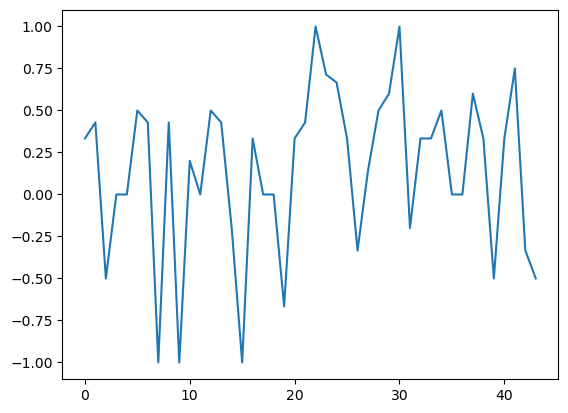

In [53]:
plt.plot(range(len(list_of_GC_skew)), list_of_GC_skew)

In [17]:
df = pd.read_csv('data/HGTDB/preprocessed_data/vvul2c2.csv', na_values=None, index_col='ID').drop(columns=["FunctionCode","Strand","Length","SD1","SD2","SD3","SDT"]) 

In [18]:
df

,GC1,GC2,GC3,GCT,Mah,AADev,HGT
ID,,,,,,,
-a_0,54.5,37.0,50.8,47.4,22.3,0,0
-b_1,53.8,35.3,54.5,47.9,80.6,1,0
-a_2,56.9,37.9,52.1,49.0,27.4,0,0
-b_3,59.2,35.5,54.6,49.8,36.9,0,0
-a_4,60.6,33.3,40.9,44.9,193.2,1,0
...,...,...,...,...,...,...,...
-a_1692,58.8,36.5,42.4,45.9,119.5,0,0
-b_1693,62.7,40.9,53.7,52.4,22.8,0,0
-a_1694,59.4,38.5,49.8,49.2,33.4,0,0


In [20]:
import matplotlib.pyplot as plt

AttributeError: Line2D.set() got an unexpected keyword argument 's'

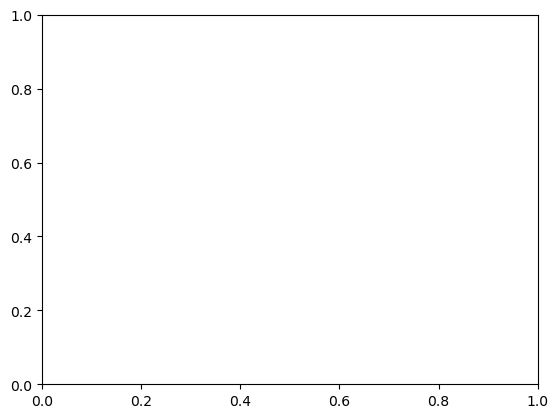

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(range(len(df)), df['GC1'], s=10, c='b', marker="s", label='first')
ax1.scatter(range(len(df)),df['GC2'], s=10, c='r', marker="o", label='second')
plt.legend(loc='upper left')
plt.show()

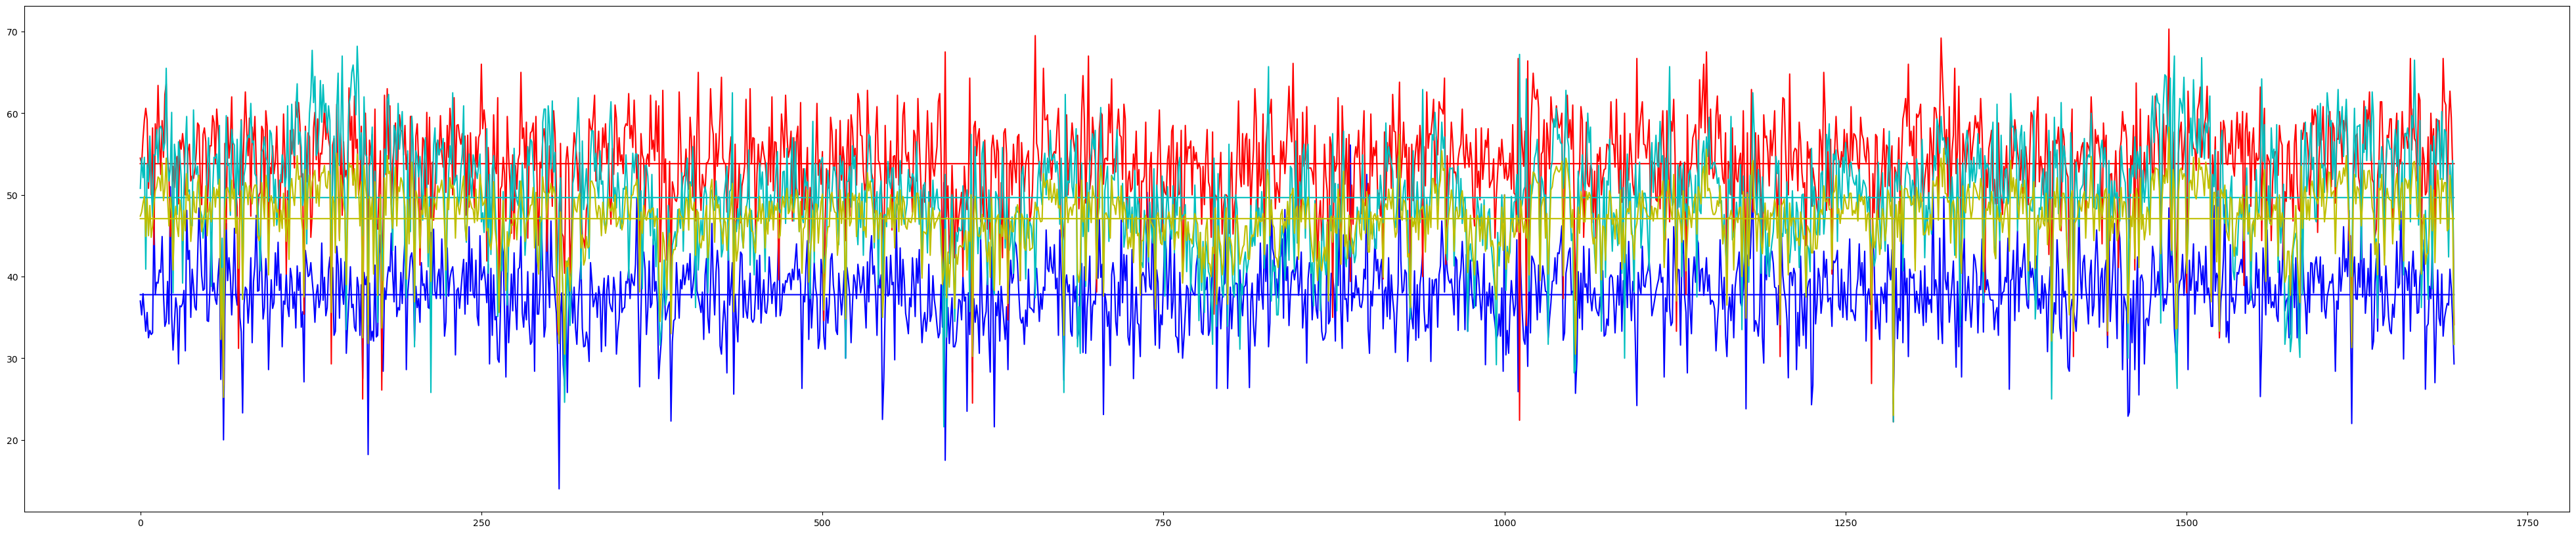

In [41]:
plt.figure(figsize=(50,10))
plt.plot(range(len(df)),df['GC2'], color='b', linestyle='solid')
plt.plot(range(len(df)), [(sum(df['GC2'])/len(df)) for i in range(len(df))], color='b', linestyle='solid')
plt.plot(range(len(df)),df['GC1'], color='r', linestyle='solid')
plt.plot(range(len(df)), [(sum(df['GC1'])/len(df)) for i in range(len(df))], color='r', linestyle='solid')
plt.plot(range(len(df)),df['GC3'], color='c', linestyle='solid')
plt.plot(range(len(df)), [(sum(df['GC3'])/len(df)) for i in range(len(df))], color='c', linestyle='solid')
plt.plot(range(len(df)),df['GCT'], color='y', linestyle='solid')
plt.plot(range(len(df)), [(sum(df['GCT'])/len(df)) for i in range(len(df))], color='y', linestyle='solid')